# Exercise 8

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

1. Run a simple linear regression relating the species richness with each one of the continuous
environmental variables in the dataset: Altitude, Actual_river_slope, Elevation_mean_catch,
prec_ann_catch, temp_ann, temp_jan, temp_jul. Before running the analyses, check if any of the
variables requires to be transformed and apply the appropriate transformation. Compute the
regression coefficient estimates, the r-square and the F-statistics. You may plot the fitted model.

In [9]:
# Read in data
df = pd.read_csv('EFIplus_medit.csv', sep=";")
df.head()

Site_code   Latitude  Longitude Country Catchment_name  Galiza  Subsample  \
0  ES_01_0002  38.102003  -4.096070   Spain   Guadalquivir       0          1   
1  ES_02_0001  40.530188  -1.887796   Spain           Tejo       0          1   
2  ES_02_0002  40.595432  -1.928079   Spain           Tejo       0          1   
3  ES_02_0003  40.656184  -1.989831   Spain           Tejo       0          1   
4  ES_02_0004  40.676402  -2.036274   Spain           Tejo       0          1   

   Calib_EFI_Medit  Calib_connect  Calib_hydrol  ...  Squalius malacitanus  \
0                0              1             0  ...                     0   
1                1              1             1  ...                     0   
2                1              1             1  ...                     0   
3                1              1             1  ...                     0   
4                1              1             1  ...                     0   

   Squalius pyrenaicus  Squalius torgalensis  Thymallus thymallus  \
0                    0                     0                    0   
1                    0                     0                    0   
2                    0                     0                    0   
3                    0                     0                    0   
4                    0                     0                    0   

   Tinca tinca Zingel asper Squalius sp  Barbatula sp Phoxinus sp  \
0            0            0           0             0           0   
1            0            0           0             0           0   
2            0            0           0             0           0   
3            0            0           0             0           0   
4            0            0           0             0           0   

   Iberochondrostoma_sp  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 164 columns]

In [10]:
# Add species richness column (ex7)
# ID the first species column
species_start = df.columns.get_loc('Abramis brama')

# Get everything from species start to the end of the df
species_df = df.iloc[:, species_start:]

# Convert absence and presence to 0/1
species_binary = (species_df > 0).astype(int)

# Sum across each row to get species richness
df['species_richness'] = species_binary.sum(axis=1)

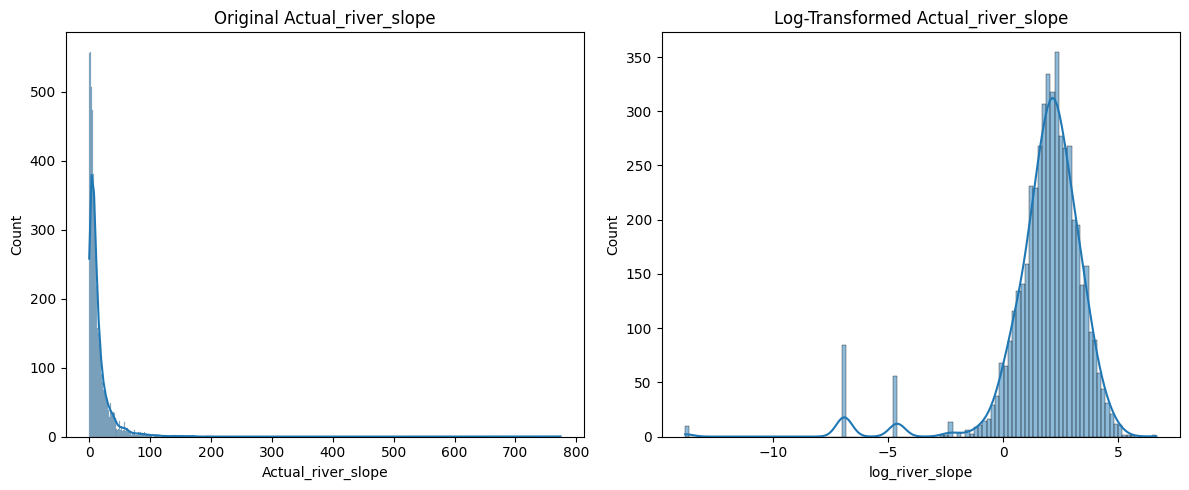

In [11]:
# Add a small constant to avoid log(0)
df["log_river_slope"] = np.log(df["Actual_river_slope"] + 1e-6)

# Create subplots for original and log-transformed distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Original distribution
sns.histplot(df["Actual_river_slope"], ax=axs[0], kde=True)
axs[0].set_title("Original Actual_river_slope")

# Log-transformed distribution
sns.histplot(df["log_river_slope"], ax=axs[1], kde=True)
axs[1].set_title("Log-Transformed Actual_river_slope")

plt.tight_layout()
plt.show()

Altitude: slope=-0.00, r²=0.103, p=0.000000
- reject H0 that the slope of the relationship is = 0
log_river_slope: slope=-0.42, r²=0.078, p=0.000000
- reject H0 that the slope of the relationship is = 0
Elevation_mean_catch: slope=-0.00, r²=0.055, p=0.000000
- reject H0 that the slope of the relationship is = 0
prec_ann_catch: slope=-0.00, r²=0.023, p=0.000000
- reject H0 that the slope of the relationship is = 0
temp_ann: slope=0.41, r²=0.095, p=0.000000
- reject H0 that the slope of the relationship is = 0
temp_jan: slope=0.22, r²=0.042, p=0.000000
- reject H0 that the slope of the relationship is = 0
temp_jul: slope=0.34, r²=0.093, p=0.000000
- reject H0 that the slope of the relationship is = 0


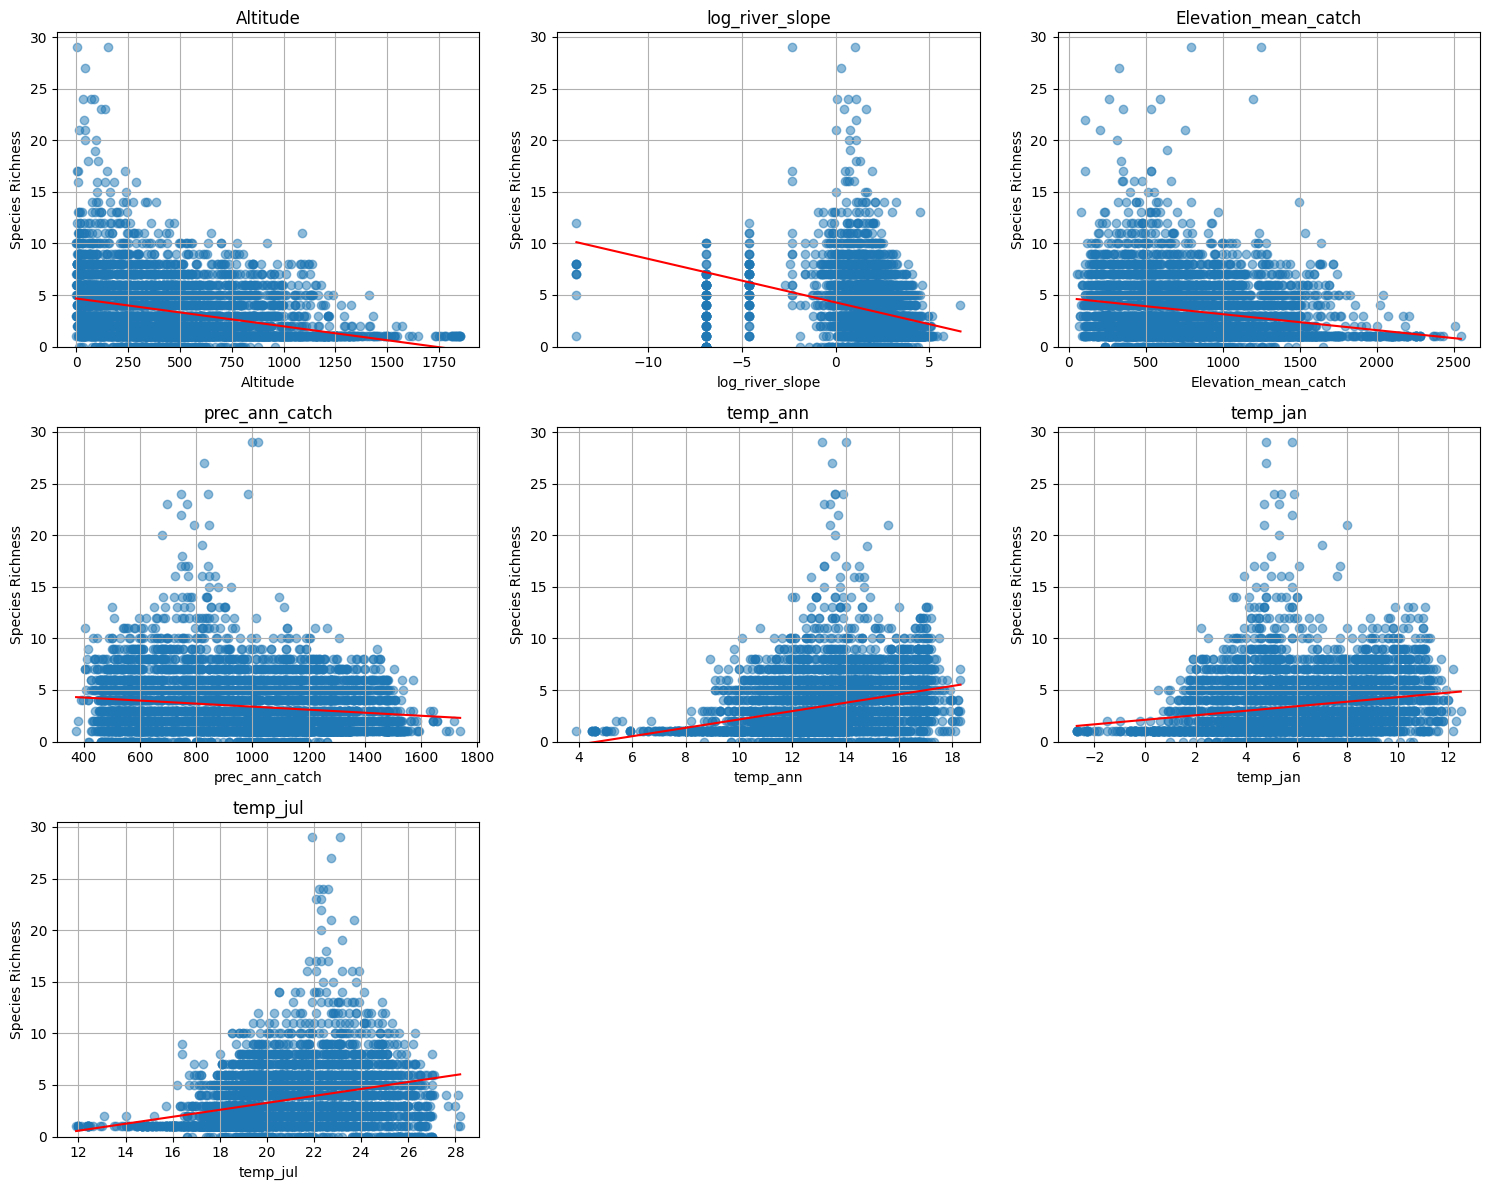

In [12]:
# List of x-variable column names to loop through
x_vars = ['Altitude', 'log_river_slope', 'Elevation_mean_catch', 
          'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul']
y = df["species_richness"]

# Define number of subplots
n_vars = len(x_vars)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # Flatten in case of single row

alpha = 0.05

for i, x_var in enumerate(x_vars):
    ax = axes[i]
    x = df[x_var]
    y_clean = y

    # Drop rows with missing values in x or y
    mask = x.notna() & y_clean.notna()
    x_clean = x[mask]
    y_clean = y_clean[mask]

    # Linear regression
    slope, intercept, r, p, std_err = stats.linregress(x_clean, y_clean)

    # Print regression results
    print(f'{x_var}: slope={slope:.2f}, r²={r**2:.3f}, p={p:.6f}')
    if p <= alpha:
        print('- reject H0 that the slope of the relationship is = 0')
    else:
        print('- fail to reject H0 that the slope of the relationship is = 0')

    # Prepare regression line
    x_sorted = np.linspace(x_clean.min(), x_clean.max(), 100)
    y_pred = intercept + slope * x_sorted

    # Plot scatter and regression line
    ax.scatter(x_clean, y_clean, alpha=0.5)
    ax.plot(x_sorted, y_pred, color="red")
    ax.set_title(f"{x_var}")
    ax.set_xlabel(x_var)
    ax.set_ylabel("Species Richness")
    ax.grid(True)
    ax.set_ylim(bottom=0)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

2. Now try to run a multiple linear regression with the same data and check the differences between the
previous univariate regression coefficients and the new coefficients. Plot the partial dependence plots
to compare responses with the previous single effects.

In [13]:
import numpy as np
import statsmodels.api as sm

# Drop rows with missing values
df_clean = df[x_vars + ["species_richness"]].dropna()

# Define X and y
X = df_clean[x_vars]
y = df_clean["species_richness"]

# Add constant (intercept)
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       species_richness   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     173.5
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          1.10e-229
Time:                        09:34:42   Log-Likelihood:                -11353.
No. Observations:                4819   AIC:                         2.272e+04
Df Residuals:                    4811   BIC:                         2.277e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.5979 

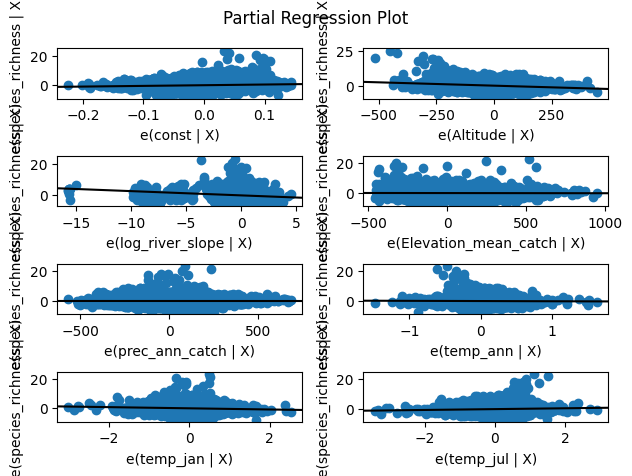

In [14]:
fig = sm.graphics.plot_partregress_grid(model)
fig.tight_layout(pad=1.0)

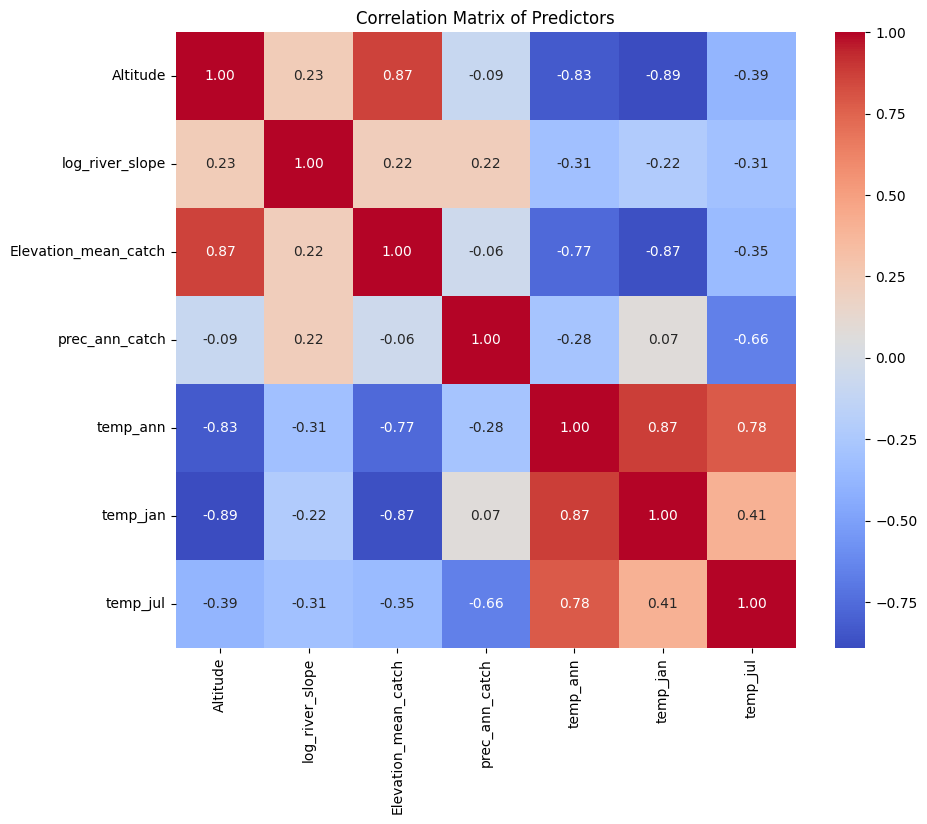

In [19]:
# Compute correlation matrix
corr_matrix = df_clean[x_vars].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.show()

In [21]:
# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# VIF > 5 = moderate multicollinearity
# VIF > 10 = serious multicollinearity - consider removing the variable

                Feature         VIF
0                 const  440.308559
1              Altitude    8.390231
2       log_river_slope    1.136445
3  Elevation_mean_catch    5.206030
4        prec_ann_catch    2.441439
5              temp_ann   73.567719
6              temp_jan   28.847790
7              temp_jul   21.230344


In [22]:
# Drop one or more variables with high VIF or strong correlation
reduced_x_vars = ['Altitude', 'log_river_slope', 'prec_ann_catch', 'temp_jul']  # <- example list, update based on VIF

# Define new X and y
X_reduced = sm.add_constant(df_clean[reduced_x_vars])
y_reduced = df_clean["species_richness"]

# Fit reduced model
reduced_model = sm.OLS(y_reduced, X_reduced).fit()

# Print summary
print(reduced_model.summary())

                            OLS Regression Results                            
Dep. Variable:       species_richness   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     241.0
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          6.50e-189
Time:                        09:39:17   Log-Likelihood:                -11456.
No. Observations:                4819   AIC:                         2.292e+04
Df Residuals:                    4814   BIC:                         2.295e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.8207      0.690     

In [23]:
# Combine coefficients
comparison = pd.DataFrame({
    'Full Model': model.params,
    'Reduced Model': reduced_model.params
})
print(comparison)

                      Full Model  Reduced Model
Altitude               -0.004818      -0.001816
Elevation_mean_catch   -0.000106            NaN
const                   4.597937       1.820677
log_river_slope        -0.269048      -0.265685
prec_ann_catch         -0.000016      -0.000380
temp_ann               -0.137786            NaN
temp_jan               -0.397746            NaN
temp_jul                0.282930       0.158988


#### Increased significance (lower p-values): Reduced multicollinearity often leads to more stable and interpretable coefficients.